### Use Machine Learning to predict the probability of needing Post-Mastectomy Radiotherapy
Author: Yifu (Charles) Chen

A notebook in Python Language

In [119]:
### Import modules ###
import os
import glob
import pandas as pd
import numpy as np
from typing import Dict
# Machine Learning Modules for Random Forest, Logistic Regression, and XGBoost
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
# Metrics
from sklearn import metrics

### Utils

In [120]:
# Setup no print limits and etc.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', False)

class bcolors:
    # Helper class to print in terminal with colors
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    NORMAL = '\033[0m'

In [121]:
from collections import OrderedDict

# Directory of DataFrames
dir_to_df = "/Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/experiments/May30 Datasets for Experiments Table (enhanced expert cols)"

# Path to log file
log_path = os.path.join(dir_to_df, "log.txt")

# Create a new log file from scratch, regardless if one exists
with open(log_path, "w") as log_file:
    log_file.write("")

def print_and_log(*args, **kwargs):
    # Helper function to print and log
    # Can write DataFrame to log file too
    print(*args, **kwargs)
    with open(log_path, "a") as log_file:
        if type(args[0]) == pd.DataFrame:
            log_file.write(args[0].to_string() + "\n")
        else:
            log_file.write("|| ".join([str(a) for a in args]) + "\n")

    
# Assume all files in directory are CSV DataFrame files
paths_to_df = glob.glob(os.path.join(dir_to_df, "*.csv"))

# Read each DataFrame file
dfs = OrderedDict()
for i, path in enumerate(paths_to_df):
    df_name = path.replace(dir_to_df, "")
    df_name = df_name.replace("/", "").replace(".csv", "")
    df = pd.read_csv(path)
    if i == len(paths_to_df) - 1:
        print("Kept the largest DF")
        df_all = df.copy()
        # dfs["df_all"] = df
    # Drop "PRE_record_id" column, if it exists
    if "PRE_record_id" in df.columns:
        df = df.drop(columns=["PRE_record_id"], axis=1)
    dfs[df_name] = df
# Sorted the dict by path name
dfs = OrderedDict(sorted(dfs.items()))

for k in dfs.keys():
    print_and_log(k)
    



Kept the largest DF
0_PRE-alan-heuristic7cols
1_PRE-expert-imputed24cols
2_PRE-expert-imputed-enhanced35cols
3_PRE-0.05spars-expert-imputed70cols
4_PRE-0.2spars-expert-imputed72cols
5_PRE-0.5spars-expert-imputed72cols
6_PRE-0.8spars-expert-imputed75cols
7_PRE-1.0spars-expert-imputed86cols
8_POS-0.05spars-expert-imputed88cols
9_POS-0.2spars-expert-imputed98cols
A_POS-0.5spars-expert-imputed105cols
B_POS-0.8spars-expert-imputed113cols
C_POS-1.0spars-expert-imputed128cols


### Pre-Process Datasets

In [122]:
# Standardize the data by removing the mean and scaling to unit variance
# The target variable is named "POS_did_the_patient_receive_pm"

dfs_std = OrderedDict()

for df_name, df in dfs.items():
    # Standardize all columns except the target column "POS_did_the_patient_receive_pm"
    df_std = df.copy()
    df_std.drop(["POS_did_the_patient_receive_pm"], axis=1, inplace=True)
    df_std = (df_std - df_std.mean()) / df_std.std()
    df_std = df_std.copy()
    # Concatenate the target column back
    df_std["POS_did_the_patient_receive_pm"] = df["POS_did_the_patient_receive_pm"]
    # Convert the target column to binary
    df_std["POS_did_the_patient_receive_pm"] = df_std["POS_did_the_patient_receive_pm"] > 0
    dfs_std[df_name] = df_std

len(dfs_std)

13

### Build Machine Learning Classifiers

In [123]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [124]:


# Initialize a dictionary for holding the models for each DataFrame
# Schema: {"DataFrame Name": {"Model Name": Model Object, ...}, ...}
from collections import defaultdict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import f1_score
import itertools

all_models = defaultdict(dict)

# The print_df contains the dataframe, model, and the average CV accuracy, AUC, and the top 6 features and their scores
# metrics_df_columns = ["Dataset", "Model", "Avg CV Accuracy", "Avg CV AUC", "Avg CV F1", "Feature_1", "Score_1", "Feature_2", "Score_2", 
#                     "Feature_3", "Score_3", "Feature_4", "Score_4", "Feature_5", "Score_5", "Feature_6", "Score_6"]

metrics_df_columns = ["Dataset", "Model"] + list(itertools.chain(*[["Avg " + m, "SE " + m] for m in ["Accuracy", "AUC", "F1"]]))

def build_classifiers(df: pd.DataFrame, df_name: str, num_folds: int=15) -> Dict[str, object]:
    """
    For each DataFrame, build the following classifiers:
        Logistic Regression
        Random Forest
        XGBoost
    Args:
        df (pd.DataFrame): the DataFrame to build the classifiers for
        df_name (str): the name of the DataFrame
    Returns:
        None
    """
    # Impute missing values with KNN
    from sklearn.impute import KNNImputer
    imputer = KNNImputer(n_neighbors=5)
    # Drop columns that are all NaN, also drop the target column
    df_drop_na = df.dropna(axis=1, how="all")
    df_drop_na = df_drop_na.drop(columns=["POS_did_the_patient_receive_pm"])
    # Impute the missing values
    df_imp = pd.DataFrame(imputer.fit_transform(df_drop_na), columns=df_drop_na.columns)
    # Put the target back
    df_imp["POS_did_the_patient_receive_pm"] = df["POS_did_the_patient_receive_pm"]
    df = df_imp.copy()

    assert df.isnull().sum().sum() == 0

    # Initialize a dictionary for holding the models for each DataFrame
    # Schema: {"Fold 1": {"Model Name": Model Object, ...}, ...}
    models = defaultdict(dict)
    performance = defaultdict(dict)
    # Train each model using 5-fold cross-validation, repeated 10 times to get error bars
    # for i in range(num_cvs):
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=0)
    for fold, (train_index, test_index) in enumerate(kf.split(df, df["POS_did_the_patient_receive_pm"])):
        fold = fold + 1
        print("Fold {}".format(fold), end="... ")
        # Split the DataFrame into training and validation sets
        df_train, df_val = df.iloc[train_index], df.iloc[test_index]
        # Build the classifiers
        models[fold] = {"Logistic Regression": LogisticRegression(),
                        "Random Forest": RandomForestClassifier(),
                        "XGBoost": XGBClassifier()
                        }
        for model_name, model in models[fold].items():
            # Train each model on the target column POS_did_the_patient_receive_pm
            model.fit(
                df_train.drop(["POS_did_the_patient_receive_pm"], axis=1),
                df_train["POS_did_the_patient_receive_pm"]
                )
            # Predict the validation set
            y_pred = model.predict(
                df_val.drop(["POS_did_the_patient_receive_pm"], axis=1)
            )
            # Calculate the accuracy of the model
            accuracy = np.mean(y_pred == df_val["POS_did_the_patient_receive_pm"])
            # Calcuilate the F1
            F1 = f1_score(y_true=df_val["POS_did_the_patient_receive_pm"], y_pred=y_pred)
            # Predict the probability of the validation set
            y_pred_proba = model.predict_proba(df_val.drop(["POS_did_the_patient_receive_pm"], axis=1))[:, 1]
            # Calculate the AUC of the model
            auc = metrics.roc_auc_score(df_val["POS_did_the_patient_receive_pm"], y_pred_proba)
            if model_name != "Logistic Regression":
                # Get the features for the model
                feature_importances = pd.Series(model.feature_importances_, index=df_train.drop(["POS_did_the_patient_receive_pm"], axis=1).columns)
            else:
                # The features for the Logistic Regression model are the coefficients
                # Take absolute value of the coefficients
                feature_importances = pd.Series(np.abs(model.coef_[0]), index=df_train.drop(["POS_did_the_patient_receive_pm"], axis=1).columns)
            # Store the accuracy, AUC, and features for the model
            performance[model_name][fold] = {"accuracy": accuracy, "auc": auc, "F1": F1, "top_features": feature_importances}
    
    # Consolidate the top features for each model
    # Schema: {"Model Name": {"Feature_1": Score_1, ...}, ...}
    feature_scores = defaultdict(lambda: defaultdict(float))
    for model_name, fold in performance.items():
        for fold_num, fold_performance in fold.items():
            # Extract feature name and importance score
            for feature_name, score in fold_performance["top_features"].items():
                feature_scores[model_name][feature_name] += score
        # Divide the feature importance scores by the number of folds
        for feature_name, score in feature_scores[model_name].items():
            feature_scores[model_name][feature_name] /= len(fold)
            # Round to 2 decimal places
            feature_scores[model_name][feature_name] = round(feature_scores[model_name][feature_name], 4)
    
    # Print the performance of each model, including averaged across folds
    # DataFrame for printing results in a nice format
    # Columns: Dataset, Model, Avg CV Accuracy, SE Accuracy, Avg CV AUC, SE AUC, Avg CV F1, SE F1
    print_df = pd.DataFrame(columns=metrics_df_columns)
    for model_name, fold in performance.items():
        accuracy = round(np.mean([fold[fold_num]["accuracy"] for fold_num in fold.keys()]), 4)
        auc = round(np.mean([fold[fold_num]["auc"] for fold_num in fold.keys()]), 4)
        F1 = round(np.mean([fold[fold_num]["F1"] for fold_num in fold.keys()]), 4)
        accuracy_se = round(np.std([fold[fold_num]["accuracy"] for fold_num in fold.keys()]) / np.sqrt(len(fold)), 4)
        auc_se = round(np.std([fold[fold_num]["auc"] for fold_num in fold.keys()]) / np.sqrt(len(fold)), 4)
        F1_se = round(np.std([fold[fold_num]["F1"] for fold_num in fold.keys()]) / np.sqrt(len(fold)), 4)
        # Convert metric and metric_se from float to string format
        # accuracy_str = str(accuracy) + " (" + str(accuracy_se) + ")"
        # auc_str = str(auc) + " (" + str(auc_se) + ")"
        # F1_str = str(F1) + " (" + str(F1_se) + ")"
        # curr_df = pd.DataFrame(
        #             [
        #                 [df_name, model_name, accuracy_str, auc_str, F1_str] +
        #                 [feat_1, score_1, feat_2, score_2, feat_3, score_3, feat_4, score_4, feat_5, score_5, feat_6, score_6]
        #             ],
        #             columns=metrics_df_columns
        #         )
        curr_df = pd.DataFrame(
                    [
                        [df_name, model_name, accuracy, accuracy_se, auc, auc_se, F1, F1_se]
                    ],
                    columns=metrics_df_columns
                )
        print_df = pd.concat(
            [
                print_df,
                curr_df
            ],
            axis=0
        )
    # Print the DataFrame with nice formatting
    # print_and_log(print_df)

    # print_and_log("="*150)
    return print_df, feature_scores


# Build the classifiers for each DataFrame
print_df = pd.DataFrame(columns=metrics_df_columns)
# Create a dictionary for holding the DataFrames for plotting
plot_dict = OrderedDict()
# Create a dictionary for holding all the feature scores across datasets and models
# Schema: {"Dataset1": {"Model1": {"Feature_1": Score_1, ...}, ...}, ...}
all_top_features = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
for df_name, df in dfs_std.items():
    print_and_log(f"Processing {df_name}...")
    print_df, feature_scores = build_classifiers(df, df_name)
    # print the DataFrame without the index
    print_and_log("")
    print_and_log(print_df.to_string(index=False))
    model_names = feature_scores.keys()
    for model in model_names:
        top_features = sorted(feature_scores[model].items(), key=lambda x: x[1], reverse=True)[:]
        print_and_log(
            "\n" + "-" * 10 + 
            f"The 1/3 ({len(top_features)//3} out of {len(top_features)}) "
            f"most important features for {model}:" + "-" * 10
        )
        for i, (feat, score) in enumerate(top_features):
            all_top_features[df_name][model][feat] = score
            # If the feature is in the top 1/3, print it
            if i < len(top_features) / 3:
                print_and_log(f"{feat}: {score}", end="\t")
        print_and_log("")
    print_and_log("="*150)
    # Add the DataFrame to the dictionary for plotting later
    plot_dict[df_name] = print_df

Processing 0_PRE-alan-heuristic7cols...
Fold 1... Fold 2... Fold 3... Fold 4... Fold 5... Fold 6... Fold 7... Fold 8... Fold 9... Fold 10... Fold 11... Fold 12... Fold 13... Fold 14... Fold 15... 
                  Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
0_PRE-alan-heuristic7cols Logistic Regression         0.67      0.0098  0.6885  0.0169   0.448  0.0256
0_PRE-alan-heuristic7cols       Random Forest       0.6567      0.0117  0.7041  0.0127  0.4567  0.0218
0_PRE-alan-heuristic7cols             XGBoost         0.65      0.0113  0.6996  0.0139  0.4653  0.0216

----------The 1/3 (2 out of 6) most important features for Logistic Regression:----------
PRE_int_mammary_lymphade_pet: 1.0718	PRE_axillary_lymphadenopathy_p: 0.586	

----------The 1/3 (2 out of 6) most important features for Random Forest:----------
PRE_axillary_lymphadenopathy: 0.2359	PRE_abnormal_lymph: 0.2354	

----------The 1/3 (2 out of 6) most important features for XGBoost:------

In [125]:
# Use different proportion subsets of DataFrame and determine the performance
# Sort df_all by "PRE_record_id"
# df_all = df_all.sort_values(by="PRE_record_id")
# # Drop "PRE_record_id" column
# df_all = df_all.drop(["PRE_record_id"], axis=1)
# for percentile in range(10, 100, 10):
#     percentage = percentile/100
#     # Take the first percentage of the DataFrame
#     df_subset = df_all.iloc[:int(len(df_all)*percentage)]
#     # Train the classifiers on the subset
#     print_df = build_classifiers(df_subset, f"{percentage}% of DataFrame")

### Plotting

In [126]:
# Import plotting libraries for machine learning experiments
import matplotlib.pyplot as plt
import seaborn as sns

plot_dir = os.path.join(dir_to_df, "plots")
# Create the directory if it doesn't exist
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Retrive the saved DataFrames, and plot the results
# Plot the results for each DataFrame on a single plot
# Reset plot parameters
plt.rcParams.update(plt.rcParamsDefault)
for use_broken_axis in [False, True]:
    for metric_name in ["Accuracy", "AUC", "F1"]:
        y_data = []
        errors = []
        x_data = []
        # Retrieve the performance for each model
        for df_name, print_df in plot_dict.items():
            # Iterate through the models of the DataFrame
            for i, row in print_df.iterrows():
                # If the model is the metric, add it to the list
                model_name = row["Model"]
                # Use regular expression to retrieve the metric and its standard error
                metric = row["Avg " + metric_name]
                error = row["SE " + metric_name]
                df_name = row["Dataset"]
                df_name = df_name.replace("/", "").replace(".csv", "")
                x_data.append(metric)
                y_data.append(df_name + " - " + model_name)
                errors.append(error)
        # Create the plot
        # The plot has spaces between the bars
        plt.figure(figsize=(30, 16))
        # Plot the gridlines
        sns.set_style("whitegrid")
        # The color of the bar should alternate between 3 colors
        colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
        # Make bars
        plt.barh(y_data, x_data, xerr=errors, color=colors, align="center", alpha=0.7)
        plt.yticks(fontsize=18)
        plt.xticks(fontsize=18)
        # Align the y-tick texts to the left
        ax = plt.gca()
        # for tick in ax.yaxis.get_majorticklabels():
        #     tick.set_horizontalalignment("left")
        # Set the labels on top of the bars
        for i, v in enumerate(x_data):
            plt.text(v + 0.05, y_data[i], str(v), color="black", fontsize=18)
        plt.gca().invert_yaxis()
        if use_broken_axis:
            # Set the range of the x-axis to be between the min - 0.1 and 1
            axis_start = min(x_data) - 0.1
            plt.xlim(axis_start, 1)

        plt.xlabel(metric_name, fontsize=20)
        plt.ylabel("Model")
        plt.title(f"{metric_name} by Model", fontsize=40)

        plt.tight_layout()
        if use_broken_axis:
            # Save the plot
            plt_name = f"{metric_name}_br_axis.png"
        else:
            plt_name = f"{metric_name}_br_axis.png"
        plt.savefig(os.path.join(plot_dir, plt_name))
        plt.close()



In [127]:
# For each dataset in all_top_features, build a DataFrame with the top features
# The features for each model is ranked by their score
# The most important features shared by all models are sorted to the top
 
# Create a dictionary for holding the feature scores per dataset
# Schema: {"Dataset1": {"Model1": {"Feature_1": score_1, ...}, ...}, ...}

# We currently only consider the Random Forest model
for dataset, model_dict in all_top_features.items():
    print_and_log("-"*50)
    print_and_log(f"Processing {dataset}...")
    # Print the number of features for this dataset
    print_and_log(f"Number of features: {len(model_dict['Random Forest'])}")
    LR_features = model_dict["Logistic Regression"]
    RF_features = model_dict["Random Forest"]
    XGB_features = model_dict["XGBoost"]
    # Sort the features by their scores
    sorted_LR_features = sorted(LR_features.items(), key=lambda x: x[1], reverse=True)
    sorted_RF_features = sorted(RF_features.items(), key=lambda x: x[1], reverse=True)
    sorted_XGB_features = sorted(XGB_features.items(), key=lambda x: x[1], reverse=True)

    # Convert each score into a rank
    rank_LR_features = {feat: i+1 for i, (feat, score) in enumerate(sorted_LR_features)}
    rank_RF_features = {feat: i+1 for i, (feat, score) in enumerate(sorted_RF_features)}
    rank_XGB_features = {feat: i+1 for i, (feat, score) in enumerate(sorted_XGB_features)}
    # Assert all the features are present in the sorted features dictionary
    assert set(rank_LR_features.keys()) == set(rank_RF_features.keys()) == set(rank_XGB_features.keys())
    # Create a DataFrame with all the features
    df = pd.DataFrame({"Features": list(rank_LR_features.keys())})
    # Calculate the feature scores for each model
    # Add the ranks of RF to the DataFrame
    df["RF_rank"] = df["Features"].map(rank_RF_features)
    # Add the ranks of LR to the DataFrame
    df["LR_rank"] = df["Features"].map(rank_LR_features)
    # Add the ranks of XGB to the DataFrame
    df["XGB_rank"] = df["Features"].map(rank_XGB_features)
    # Add a column corresponding to the overall ranking using Rank Product Statistic (geometric mean of the ranks)
    df["Rank_Product^(1/3)"] = (df["RF_rank"] * df["LR_rank"] * df["XGB_rank"]) ** (1/3)
    # Sort the DataFrame by the ranks of the features
    df = df.sort_values(by="RF_rank")
    df_rank_product = df.sort_values(by="Rank_Product^(1/3)")
    # Reset the index
    df = df.reset_index(drop=True)
    # Add Rank_Product_Rank column, where the rank is the index of the row in df_rank_product
    product_rank_map = {feat: i+1 for i, feat in enumerate(df_rank_product["Features"])}
    df["Rank_Product_Rank"] =  df["Features"].map(product_rank_map)
    
    # Keep only the top 1/3 of features (the most important features)
    df = df.iloc[:]

    # Print the DataFrame, ignoring the index
    print_and_log(df.to_string(index=False))



--------------------------------------------------
Processing 0_PRE-alan-heuristic7cols...
Number of features: 6
                      Features  RF_rank  LR_rank  XGB_rank  Rank_Product^(1/3)  Rank_Product_Rank
  PRE_axillary_lymphadenopathy        1        4         1            1.587401                  1
            PRE_abnormal_lymph        2        3         4            2.884499                  4
PRE_axillary_lymphadenopathy_p        3        2         3            2.620741                  3
  PRE_int_mammary_lymphade_pet        4        1         2            2.000000                  2
  PRE_prominent_axillary_lymph        5        6         5            5.313293                  5
PRE_internal_mammary_lymphaden        6        5         6            5.646216                  6
--------------------------------------------------
Processing 1_PRE-expert-imputed24cols...
Number of features: 22
                      Features  RF_rank  LR_rank  XGB_rank  Rank_Product^(1/3)  Rank_P

Processing 0_PRE-alan-heuristic7cols with top-0 features out of 6. This feature is random noise baseline.
Fold 1... Fold 2... Fold 3... Fold 4... Fold 5... Fold 6... Fold 7... Fold 8... Fold 9... Fold 10... Fold 11... Fold 12... Fold 13... Fold 14... Fold 15... 
                  Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
0_PRE-alan-heuristic7cols Logistic Regression         0.58      0.0026  0.4812  0.0258     0.0     0.0
0_PRE-alan-heuristic7cols       Random Forest       0.5067      0.0162  0.4717  0.0169  0.3943  0.0209
0_PRE-alan-heuristic7cols             XGBoost       0.5267       0.013  0.4835  0.0185  0.3799  0.0211
------------------------------
Processing 0_PRE-alan-heuristic7cols with top-1 features out of 6. The k-th is PRE_axillary_lymphadenopathy
Fold 1... Fold 2... Fold 3... Fold 4... Fold 5... Fold 6... Fold 7... Fold 8... Fold 9... Fold 10... Fold 11... Fold 12... Fold 13... Fold 14... Fold 15... 
                  Dataset    

<Figure size 640x480 with 0 Axes>

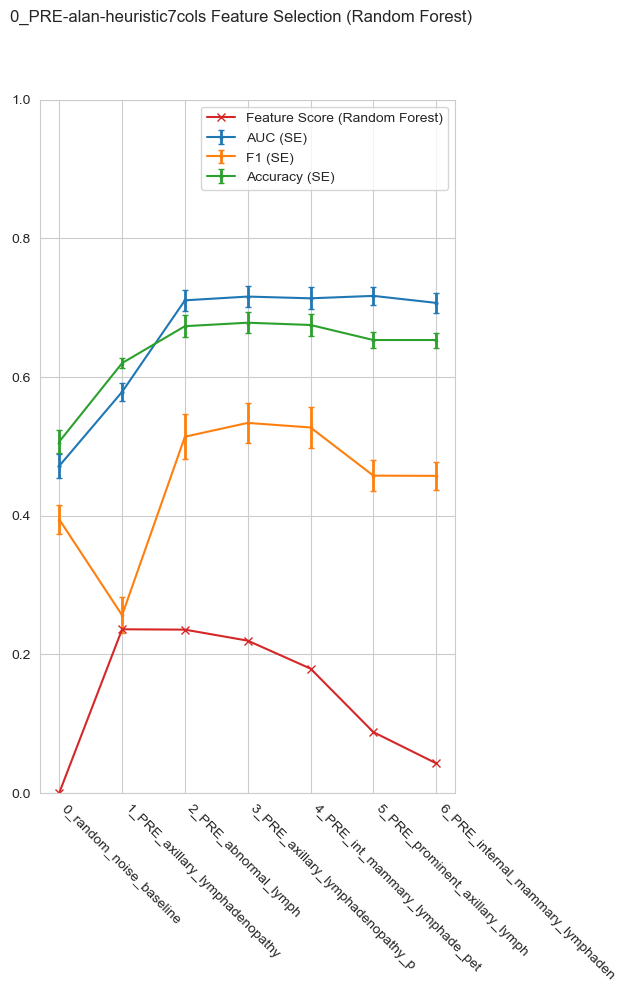

Processing 1_PRE-expert-imputed24cols with top-0 features out of 22. This feature is random noise baseline.
Fold 1... Fold 2... Fold 3... Fold 4... Fold 5... Fold 6... Fold 7... Fold 8... Fold 9... Fold 10... Fold 11... Fold 12... Fold 13... Fold 14... Fold 15... 
                   Dataset               Model Avg Accuracy SE Accuracy Avg AUC  SE AUC  Avg F1   SE F1
1_PRE-expert-imputed24cols Logistic Regression         0.58      0.0026  0.5309  0.0194     0.0     0.0
1_PRE-expert-imputed24cols       Random Forest       0.4667      0.0143  0.4645   0.014  0.3581  0.0222
1_PRE-expert-imputed24cols             XGBoost        0.485      0.0178  0.4678  0.0165  0.3356  0.0237
------------------------------
Processing 1_PRE-expert-imputed24cols with top-1 features out of 22. The k-th is PRE_img_size
Fold 1... Fold 2... Fold 3... Fold 4... Fold 5... Fold 6... Fold 7... Fold 8... Fold 9... Fold 10... Fold 11... Fold 12... Fold 13... Fold 14... Fold 15... 
                   Dataset           

In [178]:
# Conduct experiments for determining the cumulative effect of the features on the model performance
# For each dataset, train the models on the top-1 most important feature, then top-2, top-3, ...
# Save the results of each experiment in a dictionary
# Import sleep module to allow the program to pause for a few seconds
import time
# def ... TODO: wrap the following code into a neat, reusable function
num_folds = 15
model_name = "Random Forest"
target_column = "POS_did_the_patient_receive_pm"
metrics_df = pd.DataFrame(columns=metrics_df_columns)
# Create a dictionary for holding the DataFrames for plotting
# Schema: {"Dataset1": {"Top1_feature": metrics_df1, "Top2_feature": metrics_df2, ...}, ...}
plot_dict2 = defaultdict(OrderedDict)
# Re-use the all_top_features dictionary for deciding the order of the features to use

for df_name in all_top_features:
    # Create a DataFrame for the top-k most important feature
    # Sort all features by feature scores
    all_features_sorted = [f[0] for f in sorted(all_top_features[df_name][model_name].items(), key=lambda x: x[1], reverse=True)]
    num_features = len(all_features_sorted)
    df_all_features = dfs_std[df_name]
    for k in range(0, num_features+1):
        if k == 0:
            # Random noise baseline
            top_k_features = "random_noise_baseline"
            print_and_log(f"Processing {df_name} with top-{k} features out of {num_features}. This feature is random noise baseline.")
            df_top_k_features = df_all_features[[target_column]]
            noise_data = np.random.rand(len(df_top_k_features))
            df_top_k_features.insert(0, "0_random_noise_baseline", noise_data)
            assert len(df_top_k_features.columns) == 2
        else:
            # Get the top-k most important features
            top_k_features = all_features_sorted[:k]
            print_and_log(f"Processing {df_name} with top-{k} features out of {num_features}. The k-th is {top_k_features[-1]}")
            # Create a DataFrame for the top-k most important features, and the target variable
            df_top_k_features = df_all_features[top_k_features + [target_column]]
            assert len(df_top_k_features.columns) == k + 1
        metrics_df, feature_scores = build_classifiers(df_top_k_features, df_name, num_folds=num_folds)
        # print metrics_df, without index
        print_and_log("")
        print_and_log(metrics_df.to_string(index=False, justify="right"))
        print_and_log("-"*30)
        # Add the DataFrame to the dictionary for plotting later
        plot_dict2[df_name][k] = metrics_df
        # Sleep for a few seconds to cool down the hardware
        time.sleep(3)
    print("="*150)
    # Plot the metrics on the top-k most important features
    # The X-axis is the number of features, with the kth feature as label
    # The Y-axis is the metrics, with three types of metrics shown in separate markers
    # The Y-axis also shows the metric scores for each feature
    # The metrics are AUC, F1, and Accuracy, which are saved in metrics_df
    # The legend is the type of the metric
    # Use tight layout
    plt.tight_layout()
    fig, ax = plt.subplots()
    # Set the title of the figure
    fig.suptitle(f"{df_name} Feature Selection ({model_name})")
    marker_map = {"AUC": "o", "F1": "s", "Accuracy": "^"}
    for metric_name in ["AUC", "F1", "Accuracy"]:
        # Create figure
        plt_name = f"{df_name}_top_features_metrics.png"
        x_data = [i for i in range(1, num_features+1)]
        # Append the feature name to each x_data
        x_data = ["0_random_noise_baseline"] + [f"{i}_{all_features_sorted[i-1]}" for i in x_data]
        model_idx = metrics_df["Model"].values.tolist().index(model_name)
        y_data = []
        y_err = []
        for metrics_df in plot_dict2[df_name].values():
            # Get the data for plotting
            y_data.append(metrics_df["Avg " + metric_name].values[model_idx])
            y_err.append(metrics_df["SE " + metric_name].values[model_idx])
        # Plot the data
        ax.errorbar(
            x_data,
            y_data,
            yerr=y_err,
            marker=marker_map[metric_name],
            label=metric_name + " (SE)",
            ms=2,
            capsize=2,
            barsabove=True,
            elinewidth=2
        )
        # Rotate the x-axis labels
    # Add feature scores
    y_data = [0]
    for feature, score in sorted(all_top_features[df_name][model_name].items(), key=lambda x: x[1], reverse=True):
        y_data.append(score)
    ax.plot(x_data, y_data, marker="x", label=f"Feature Score ({model_name})")
    # Set the marker size to smaller sizes so error bars can be seen
    # Make the x-axis labels smaller if len_x_data is too long
    x_tick_size = 10 if len(x_data) < 30 else 6
    plt.xticks(rotation=-45, ha="left", size=x_tick_size)
    # Add legend
    ax.legend(loc="best")
    # Enforce the range of the y-axis
    ax.set_ylim(0, 1.0)
    fig.set_size_inches(len(x_data) * 0.05 + 5, 9)
    plt.show()
    # Save the figure
    # Adjust plot size, let the width be proportional to the length of x-data
    plt_path = os.path.join(plot_dir, plt_name)
    fig.tight_layout()
    fig.savefig(plt_path, dpi=500)
    # Sleep for two minutes to cool down the hardware
    time.sleep(120)


In [ ]:
plot_dir

'/Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/experiments/May26 Datasets for Experiments Table (enhanced expert cols)/plots'